### Implementation Outline
- Preprocessing:

Data cleaning and feature engineering.
Calculation of OFI.
- Modeling (VAR):

Fit a VAR model on historical buy/sell orders.
Predict future buy/sell orders using the VAR model.
- Modeling (Neural Network):

Calculate residuals between actual OFI and VAR-predicted OFI.
Train a neural network on these residuals.
- UDE Combination:

Combine VAR predictions and neural network-predicted residuals to get final OFI predictions.
- Testing and Evaluation:

Test the UDE model on the continuation data and evaluate the performance.

In [2]:
import pandas as pd

# Load the data from the CSV file
file_path = 'train10000_syn1.csv'  # Change this to the correct file path
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df['Time'] = pd.to_datetime(df['Time'])

# Set the 'Time' column as the index
df.set_index('Time', inplace=True)

# Filter for BUY and SELL orders
buy_orders = df['buy_orders']
sell_orders = df['sell_orders']


In [3]:
df

,buy_orders,sell_orders
Time,,
2024-10-14 07:53:48,102,148
2024-10-14 07:53:49,435,87
2024-10-14 07:53:50,348,323
2024-10-14 07:53:51,270,382
2024-10-14 07:53:52,106,395
...,...,...
2024-10-14 10:40:23,56,137
2024-10-14 10:40:24,111,253
2024-10-14 10:40:25,4,4


In [4]:
order_counts=df

In [5]:
# Calculate OFI, avoid division by zero
order_counts['OFI'] = (order_counts['buy_orders'] - order_counts['sell_orders']) / (order_counts['buy_orders'] + order_counts['sell_orders'])

# Fill any NaN values (in case of zero division) with 0
order_counts['OFI'].fillna(0, inplace=True)

# Display the calculated OFI values
print(order_counts.head())


                     buy_orders  sell_orders       OFI
Time                                                  
2024-10-14 07:53:48         102          148 -0.184000
2024-10-14 07:53:49         435           87  0.666667
2024-10-14 07:53:50         348          323  0.037258
2024-10-14 07:53:51         270          382 -0.171779
2024-10-14 07:53:52         106          395 -0.576846


C:\Users\user\AppData\Local\Temp\ipykernel_40040\3576943439.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  order_counts['OFI'].fillna(0, inplace=True)


In [6]:
order_counts

,buy_orders,sell_orders,OFI
Time,,,
2024-10-14 07:53:48,102,148,-0.184000
2024-10-14 07:53:49,435,87,0.666667
2024-10-14 07:53:50,348,323,0.037258
2024-10-14 07:53:51,270,382,-0.171779
2024-10-14 07:53:52,106,395,-0.576846
...,...,...,...
2024-10-14 10:40:23,56,137,-0.419689
2024-10-14 10:40:24,111,253,-0.390110
2024-10-14 10:40:25,4,4,0.000000


VAR implementation

In [7]:
# Prepare the data for the VAR model by selecting buy_orders and sell_orders
var_data = order_counts[['buy_orders', 'sell_orders']]

# Check for any missing values and fill with 0 if necessary
var_data = var_data.fillna(0)

# Display the first few rows to ensure the data is ready
print(var_data.head())


                     buy_orders  sell_orders
Time                                        
2024-10-14 07:53:48         102          148
2024-10-14 07:53:49         435           87
2024-10-14 07:53:50         348          323
2024-10-14 07:53:51         270          382
2024-10-14 07:53:52         106          395


In [8]:
from statsmodels.tsa.api import VAR

# Fit the VAR model
model = VAR(var_data)

# Select the optimal lag length using criteria like AIC, BIC, etc.
lag_order = 2

# Fit the VAR model with this lag order
var_model = model.fit(lag_order)

# Print the model summary to ensure it is fitted correctly
print(var_model.summary())


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 22, Oct, 2024
Time:                     15:54:22
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    19.8952
Nobs:                     9998.00    HQIC:                   19.8904
Log likelihood:          -127783.    FPE:                4.33745e+08
AIC:                      19.8880    Det(Omega_mle):     4.33311e+08
--------------------------------------------------------------------
Results for equation buy_orders
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                248.383023         5.196191           47.801           0.000
L1.buy_orders          0.012076         0.010002            1.207           0.227
L1.sell_orders         0.001914         0.010018   

c:\Users\user\miniconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency s will be used.
  self._init_dates(dates, freq)


In [9]:
# Forecast future values (e.g., the next 10 steps)
forecast_steps = 10
var_forecast = var_model.forecast(var_data.values[-lag_order:], steps=forecast_steps)

# Convert the forecast to a DataFrame for easier handling
forecast_df = pd.DataFrame(var_forecast, columns=['buy_orders_forecast', 'sell_orders_forecast'])

# Display the forecasted values
print(forecast_df)



   buy_orders_forecast  sell_orders_forecast
0           250.756212            244.387986
1           251.389700            247.380753
2           249.873181            248.113644
3           249.821558            248.098946
4           249.805555            248.105910
5           249.805347            248.106583
6           249.805193            248.106656
7           249.805183            248.106654
8           249.805181            248.106655
9           249.805181            248.106655


In [10]:
from statsmodels.tsa.stattools import adfuller

# Check stationarity of buy_orders and sell_orders
result_buy = adfuller(var_data['buy_orders'])
result_sell = adfuller(var_data['sell_orders'])

print('Buy Orders ADF Statistic:', result_buy[0])
print('Buy Orders p-value:', result_buy[1])
print('Sell Orders ADF Statistic:', result_sell[0])
print('Sell Orders p-value:', result_sell[1])


Buy Orders ADF Statistic: -98.79460428422429
Buy Orders p-value: 0.0
Sell Orders ADF Statistic: -100.32263808770855
Sell Orders p-value: 0.0


In [11]:
lag_order = 2

# Fit the VAR model with this lag order
var_model = model.fit(lag_order)
var_forecast = var_model.forecast(var_data.values[-lag_order:], steps=forecast_steps)

# Convert the forecast to a DataFrame for easier handling
forecast_df = pd.DataFrame(var_forecast, columns=['buy_orders_forecast', 'sell_orders_forecast'])

# Display the forecasted values
print(forecast_df)


   buy_orders_forecast  sell_orders_forecast
0           250.756212            244.387986
1           251.389700            247.380753
2           249.873181            248.113644
3           249.821558            248.098946
4           249.805555            248.105910
5           249.805347            248.106583
6           249.805193            248.106656
7           249.805183            248.106654
8           249.805181            248.106655
9           249.805181            248.106655


In [12]:
var_model.fittedvalues

,buy_orders,sell_orders
Time,,
2024-10-14 07:53:50,252.375387,248.649234
2024-10-14 07:53:51,253.901682,246.564896
2024-10-14 07:53:52,249.774100,246.044580
2024-10-14 07:53:53,246.763423,247.922256
2024-10-14 07:53:54,245.280753,249.925057
...,...,...
2024-10-14 10:40:23,245.771793,248.407769
2024-10-14 10:40:24,246.424143,252.520224
2024-10-14 10:40:25,248.729312,251.990820


In [13]:
var_data[['buy_orders', 'sell_orders']]

,buy_orders,sell_orders
Time,,
2024-10-14 07:53:48,102,148
2024-10-14 07:53:49,435,87
2024-10-14 07:53:50,348,323
2024-10-14 07:53:51,270,382
2024-10-14 07:53:52,106,395
...,...,...
2024-10-14 10:40:23,56,137
2024-10-14 10:40:24,111,253
2024-10-14 10:40:25,4,4


Align it to same start time

In [15]:
# Align var_data with the fitted values by dropping the initial rows (based on lag order)
fitted_values = var_model.fittedvalues
aligned_var_data = var_data.iloc[len(var_data) - len(fitted_values):]  # Aligning the lengths

# Calculate residuals between the actual data and the VAR model's fitted values
residuals = aligned_var_data[['buy_orders', 'sell_orders']] - fitted_values

# Fill any missing residuals (if any) with 0
residuals.fillna(0, inplace=True)

# Display the aligned data and residuals
print("Aligned VAR Data:")
print(aligned_var_data.head())
print("Residuals:")
print(residuals.head())


Aligned VAR Data:
                     buy_orders  sell_orders
Time                                        
2024-10-14 07:53:50         348          323
2024-10-14 07:53:51         270          382
2024-10-14 07:53:52         106          395
2024-10-14 07:53:53          71          277
2024-10-14 07:53:54         188          403
Residuals:
                     buy_orders  sell_orders
Time                                        
2024-10-14 07:53:50   95.624613    74.350766
2024-10-14 07:53:51   16.098318   135.435104
2024-10-14 07:53:52 -143.774100   148.955420
2024-10-14 07:53:53 -175.763423    29.077744
2024-10-14 07:53:54  -57.280753   153.074943


In [16]:
residuals

,buy_orders,sell_orders
Time,,
2024-10-14 07:53:50,95.624613,74.350766
2024-10-14 07:53:51,16.098318,135.435104
2024-10-14 07:53:52,-143.774100,148.955420
2024-10-14 07:53:53,-175.763423,29.077744
2024-10-14 07:53:54,-57.280753,153.074943
...,...,...
2024-10-14 10:40:23,-189.771793,-111.407769
2024-10-14 10:40:24,-135.424143,0.479776
2024-10-14 10:40:25,-244.729312,-247.990820


Fit NN for residuals

In [17]:
X = aligned_var_data[['buy_orders', 'sell_orders']]  # Use the original aligned buy/sell orders as features
y = residuals[['buy_orders', 'sell_orders']]

In [18]:
X, y

(                     buy_orders  sell_orders
 Time                                        
 2024-10-14 07:53:50         348          323
 2024-10-14 07:53:51         270          382
 2024-10-14 07:53:52         106          395
 2024-10-14 07:53:53          71          277
 2024-10-14 07:53:54         188          403
 ...                         ...          ...
 2024-10-14 10:40:23          56          137
 2024-10-14 10:40:24         111          253
 2024-10-14 10:40:25           4            4
 2024-10-14 10:40:26         409          371
 2024-10-14 10:40:27         413          175
 
 [9998 rows x 2 columns],
                      buy_orders  sell_orders
 Time                                        
 2024-10-14 07:53:50   95.624613    74.350766
 2024-10-14 07:53:51   16.098318   135.435104
 2024-10-14 07:53:52 -143.774100   148.955420
 2024-10-14 07:53:53 -175.763423    29.077744
 2024-10-14 07:53:54  -57.280753   153.074943
 ...                         ...          ...
 2024-

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Display the sizes of training and testing data
print(f"Training data size: {len(X_train)}")
print(f"Testing data size: {len(X_test)}")

Training data size: 7998
Testing data size: 2000


In [18]:
from sklearn.preprocessing import MinMaxScaler

In [36]:
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# y_scaler = MinMaxScaler()
# y_train_scaled = y_scaler.fit_transform(y_train)
# y_test_scaled = y_scaler.transform(y_test)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
# Define the neural network architecture
model_nn = Sequential()

# Input layer with two input features (buy_orders, sell_orders)
model_nn.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
model_nn.add(Dense(16, activation='relu'))  # Hidden layer
model_nn.add(Dense(2))  # Output layer (2 neurons for buy_orders and sell_orders residuals)

# Compile the model with mean squared error loss
model_nn.compile(optimizer='adam', loss='mean_squared_error')
# model_nn.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')

# # Train the model again
# history = model_nn.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

# Train the model (reduce the number of epochs due to small dataset)
history = model_nn.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test))
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # # Train the neural network with early stopping
# history = model_nn.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping])


c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 10740.9854 - val_loss: 7014.6572
Epoch 2/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6897.4033 - val_loss: 6768.3149
Epoch 3/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6643.0039 - val_loss: 6399.6846
Epoch 4/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6108.9263 - val_loss: 5623.6357
Epoch 5/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5158.6338 - val_loss: 4162.2246
Epoch 6/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3684.7344 - val_loss: 2050.4421
Epoch 7/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1602.6667 - val_loss: 507.0237
Epoch 8/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 335.4656 - val_loss: 75.1897
Epoch 9/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 54.5267 - val_loss: 46.9025
Epoch 10/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 37.1752 - val_loss: 43.6204
Epoch 11/100
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 37.9270 - val_loss

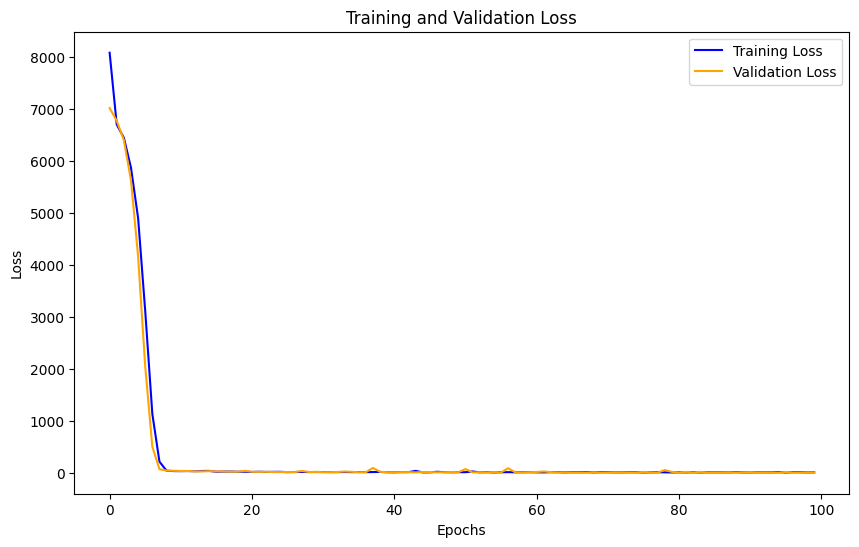

In [22]:
import matplotlib.pyplot as plt

# Plot training loss and validation loss
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(history.history['loss'], label='Training Loss', color='blue')
# Plot validation loss
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
# Show the plot
plt.show()

In [23]:
# test_loss = model_nn.evaluate(X_test_scaled, y_test_scaled)
# print(f'Test Loss: {test_loss}')

# # Predict residuals for the test set
# predicted_residuals = model_nn.predict(X_test_scaled)

# # Display the predicted residuals
# print(predicted_residuals[:5])


In [23]:
# Evaluate the model on the test data
test_loss = model_nn.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

# Predict residuals for the test set
predicted_residuals = model_nn.predict(X_test)

# Display the predicted residuals
print(predicted_residuals[:5])


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10.3364  
Test Loss: 10.379249572753906
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[-189.57924    213.5109   ]
 [-170.94563     -2.9041147]
 [ -56.708454   -91.59184  ]
 [  36.78372    218.07695  ]
 [-231.35915    204.69101  ]]


In [88]:
# from sklearn.preprocessing import MinMaxScaler

# # Normalize the input features (buy_orders, sell_orders) to be in the range [0, 1]
# scaler = MinMaxScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# y_scaler = MinMaxScaler()
# y_train_scaled = y_scaler.fit_transform(y_train)
# y_test_scaled = y_scaler.transform(y_test)
# # Train the neural network on the scaled data
# history = model_nn.fit(X_train_scaled, y_train, epochs=30, batch_size=8, validation_data=(X_test_scaled, y_test))


In [89]:
# Define a simpler neural network architecture with dropout to avoid overfitting
# from tensorflow.keras.layers import Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# model_nn = Sequential()
# model_nn.add(Dense(8, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_scaled.shape[1],)))  # Single hidden layer
# model_nn.add(Dense(2))  # Output layer

# # Compile the model
# model_nn.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')

# Train the model again
# history = model_nn.fit(X_train_scaled, y_train, epochs=30, batch_size=8, validation_data=(X_test_scaled, y_test))


c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [92]:
# from tensorflow.keras.callbacks import EarlyStopping

# # Early stopping to stop training when validation loss stops improving
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# # Train the neural network with early stopping
# history = model_nn.fit(X_train_scaled, y_train, epochs=30, batch_size=8, validation_data=(X_test_scaled, y_test_scaled), callbacks=[early_stopping])


In [23]:
# # Evaluate the model on the test data
# test_loss = model_nn.evaluate(X_test, y_test)
# print(f'Test Loss: {test_loss}')

# # Predict residuals for the test set
# predicted_residuals = model_nn.predict(X_test)

# # Display the predicted residuals
# print(predicted_residuals[:5])

In [24]:
var_forecast_test = var_model.forecast(X_test.values, steps=len(X_test))

# Combine VAR predictions and predicted residuals
final_forecast = var_forecast_test + predicted_residuals

# Display the final forecast (buy_orders and sell_orders predictions with residuals)
print(final_forecast[:5])


[[ 61.17697285 457.89888124]
 [ 80.44406703 244.47663827]
 [193.16472735 156.52180122]
 [286.60527621 466.17589595]
 [ 18.44640921 452.79691985]]


In [27]:
# X_test_scaled

In [25]:
X_test

,buy_orders,sell_orders
Time,,
2024-10-14 10:07:08,56,457
2024-10-14 10:07:09,77,243
2024-10-14 10:07:10,193,156
2024-10-14 10:07:11,284,463
2024-10-14 10:07:12,14,448
...,...,...
2024-10-14 10:40:23,56,137
2024-10-14 10:40:24,111,253
2024-10-14 10:40:25,4,4


In [26]:
# Calculate the actual OFI for the test data
actual_ofi = (X_test['buy_orders'] - X_test['sell_orders']) / (X_test['buy_orders'] + X_test['sell_orders'])
actual_ofi.fillna(0, inplace=True)  # Handle any NaN values (e.g., when both buy and sell orders are zero)

# Display the actual OFI values
print(actual_ofi.head())


Time
2024-10-14 10:07:08   -0.781676
2024-10-14 10:07:09   -0.518750
2024-10-14 10:07:10    0.106017
2024-10-14 10:07:11   -0.239625
2024-10-14 10:07:12   -0.939394
dtype: float64


In [27]:
# Combine VAR predictions and neural network residuals
final_ofi_predictions = (final_forecast[:, 0] - final_forecast[:, 1]) / (final_forecast[:, 0] + final_forecast[:, 1])

# Display the predicted OFI values
print(final_ofi_predictions[:5])


[-0.76428504 -0.50483878  0.10478793 -0.23854292 -0.92171174]


In [28]:
final_ofi_predictions

array([-0.76428504, -0.50483878,  0.10478793, ..., -0.15973408,
        0.04772304,  0.40513984])

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate evaluation metrics
mse = mean_squared_error(actual_ofi, final_ofi_predictions)
mae = mean_absolute_error(actual_ofi, final_ofi_predictions)
r2 = r2_score(actual_ofi, final_ofi_predictions)

# Print the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared: {r2}')


Mean Squared Error (MSE): 0.0006680931310410703
Mean Absolute Error (MAE): 0.005339032863136277
R-squared: 0.9971251965131204


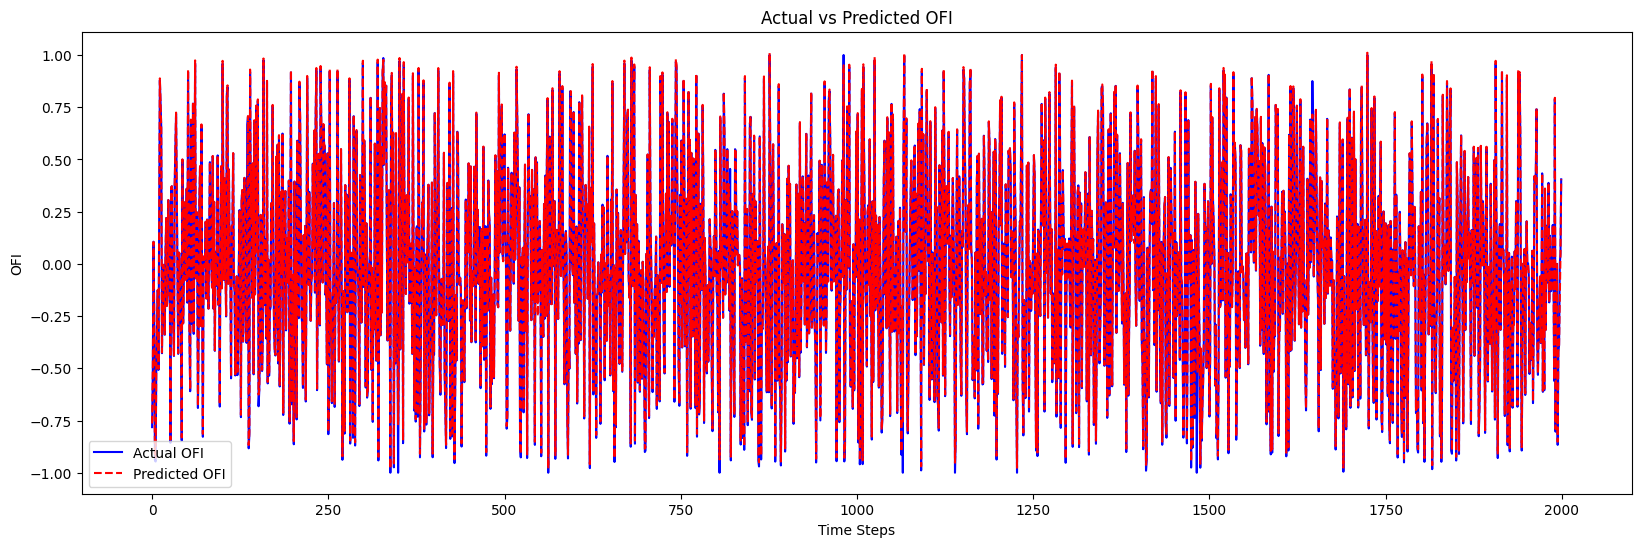

In [31]:
import matplotlib.pyplot as plt

# Plot the actual vs predicted OFI
plt.figure(figsize=(20, 6))
plt.plot(actual_ofi.values, label='Actual OFI', color='blue')
plt.plot(final_ofi_predictions, label='Predicted OFI', color='red', linestyle='dashed')
plt.xlabel('Time Steps')
plt.ylabel('OFI')
plt.title('Actual vs Predicted OFI')
plt.legend()
plt.show()

In [32]:
# Load the continuation data from '75000_trades_25.csv'
continuation_file_path = 'test3000_syn1.csv'
continuation_data = pd.read_csv(continuation_file_path)

# Convert 'Time' column to datetime format and set as index
continuation_data['Time'] = pd.to_datetime(continuation_data['Time'])
continuation_data.set_index('Time', inplace=True)

order_counts_cont=continuation_data

# Display the first few rows of the continuation data
print(order_counts_cont.head())


                     buy_orders  sell_orders
Time                                        
2024-10-14 10:40:28         181          372
2024-10-14 10:40:29          12          409
2024-10-14 10:40:30         338          213
2024-10-14 10:40:31         284          363
2024-10-14 10:40:32         258           22


In [33]:
order_counts_cont['OFI'] = (order_counts_cont['buy_orders'] - order_counts_cont['sell_orders']) / (order_counts_cont['buy_orders'] + order_counts_cont['sell_orders'])
order_counts_cont['OFI'].fillna(0, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_40040\724105446.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  order_counts_cont['OFI'].fillna(0, inplace=True)


In [34]:
print(order_counts_cont.head())

                     buy_orders  sell_orders       OFI
Time                                                  
2024-10-14 10:40:28         181          372 -0.345389
2024-10-14 10:40:29          12          409 -0.942993
2024-10-14 10:40:30         338          213  0.226860
2024-10-14 10:40:31         284          363 -0.122102
2024-10-14 10:40:32         258           22  0.842857


In [35]:
# Prepare the continuation data for the VAR model
var_cont_data = order_counts_cont[['buy_orders', 'sell_orders']].fillna(0)

# Use the trained VAR model to forecast buy and sell orders
var_forecast_cont = var_model.forecast(var_cont_data.values[:len(X_test)], steps=len(var_cont_data))

# Convert the VAR forecast to a DataFrame
var_forecast_df_cont = pd.DataFrame(var_forecast_cont, columns=['buy_orders_forecast', 'sell_orders_forecast'])

# Display the forecasted buy and sell orders for the continuation data
print(var_forecast_df_cont.head())


   buy_orders_forecast  sell_orders_forecast
0           254.271463            248.722199
1           251.190596            247.076440
2           249.830567            248.055092
3           249.823909            248.103572
4           249.806148            248.106664


In [92]:
# var_cont_scaled

array([[0.08617234, 0.09619238],
       [0.05811623, 0.03406814],
       [0.07014028, 0.08416834],
       ...,
       [0.04809619, 0.02004008],
       [0.00400802, 0.05611222],
       [0.01603206, 0.08817635]])

In [36]:
# Normalize the continuation data using the same scaler used for the training data
# var_cont_scaled = scaler.transform(var_cont_data)

# Predict residuals using the neural network
predicted_residuals_cont = model_nn.predict(var_cont_data)

# Display the predicted residuals
print(predicted_residuals_cont[:5])


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
[[ -66.38843   126.78534 ]
 [-233.74709   165.28911 ]
 [  87.79965   -34.937866]
 [  35.751095  117.012985]
 [   6.423413 -227.44464 ]]


In [37]:
# Combine VAR predictions and neural network residuals for final OFI forecast
final_forecast_cont = var_forecast_cont + predicted_residuals_cont

# Calculate the final OFI predictions for the continuation data
final_ofi_predictions_cont = (final_forecast_cont[:, 0] - final_forecast_cont[:, 1]) / (final_forecast_cont[:, 0] + final_forecast_cont[:, 1])
final_ofi_predictions_cont = pd.Series(final_ofi_predictions_cont).fillna(0)  # Handle any NaN values

# Display the final OFI predictions for the continuation data
print(final_ofi_predictions_cont.head())


0   -0.333027
1   -0.918831
2    0.226080
3   -0.122242
4    0.850757
dtype: float64


In [38]:
# Calculate OFI predictions using only the VAR model for the continuation data
var_ofi_predictions_cont = (var_forecast_df_cont['buy_orders_forecast'] - var_forecast_df_cont['sell_orders_forecast']) / (var_forecast_df_cont['buy_orders_forecast'] + var_forecast_df_cont['sell_orders_forecast'])
var_ofi_predictions_cont.fillna(0, inplace=True)

# Compare VAR-only OFI with actual OFI from continuation data
actual_ofi_cont = order_counts_cont['OFI']

# Calculate evaluation metrics for the VAR-only model
mse_var = mean_squared_error(actual_ofi_cont, var_ofi_predictions_cont)
mae_var = mean_absolute_error(actual_ofi_cont, var_ofi_predictions_cont)
r2_var = r2_score(actual_ofi_cont, var_ofi_predictions_cont)

print(f'VAR-only Model - MSE: {mse_var}, MAE: {mae_var}, R-squared: {r2_var}')


VAR-only Model - MSE: 0.22785135350302774, MAE: 0.3868018144661964, R-squared: -0.00012988626439480733


In [39]:
# Calculate evaluation metrics for the combined model
mse_combined = mean_squared_error(actual_ofi_cont, final_ofi_predictions_cont)
mae_combined = mean_absolute_error(actual_ofi_cont, final_ofi_predictions_cont)
r2_combined = r2_score(actual_ofi_cont, final_ofi_predictions_cont)

print(f'Combined VAR + Neural Network Model - MSE: {mse_combined}, MAE: {mae_combined}, R-squared: {r2_combined}')


Combined VAR + Neural Network Model - MSE: 0.00017648991993633362, MAE: 0.004156447964168761, R-squared: 0.9992253157998011


In [40]:
var_ofi_predictions_cont.values


array([0.01103247, 0.00825693, 0.00356603, ..., 0.0034113 , 0.0034113 ,
       0.0034113 ])

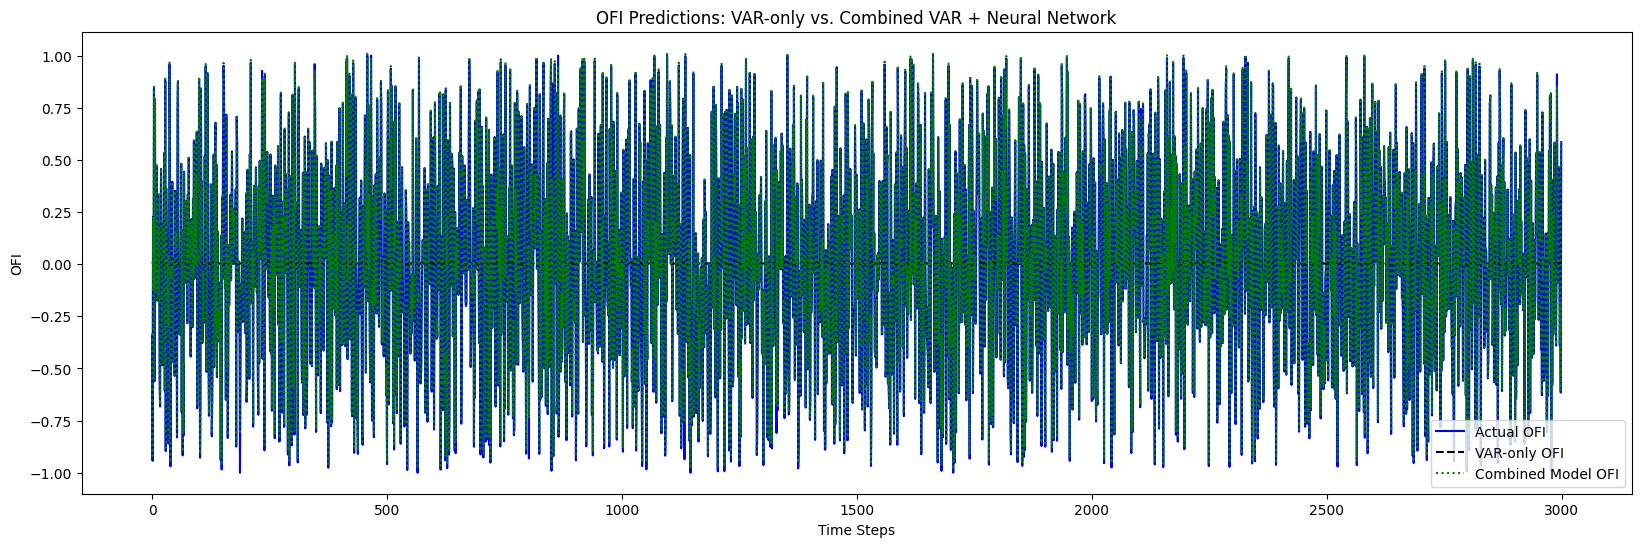

In [41]:
# Plot actual OFI vs predicted OFI from both models
plt.figure(figsize=(20, 6))
plt.plot(actual_ofi_cont.values, label='Actual OFI', color='blue')
plt.plot(var_ofi_predictions_cont.values, label='VAR-only OFI', color='black', linestyle='dashed')
plt.plot(final_ofi_predictions_cont.values, label='Combined Model OFI', color='green', linestyle='dotted')
plt.xlabel('Time Steps')
plt.ylabel('OFI')
plt.title('OFI Predictions: VAR-only vs. Combined VAR + Neural Network')
plt.legend()
plt.show()


In [42]:
# Combine actual and predicted OFI into a DataFrame
comparison_df = pd.DataFrame({
    'Actual_OFI': actual_ofi_cont.values,
    'VAR_Only_OFI': var_ofi_predictions_cont.values,
    'Combined_Model_OFI': final_ofi_predictions_cont.values
})

# Display the DataFrame
print(comparison_df.head())


   Actual_OFI  VAR_Only_OFI  Combined_Model_OFI
0   -0.345389      0.011032           -0.333027
1   -0.942993      0.008257           -0.918831
2    0.226860      0.003566            0.226080
3   -0.122102      0.003455           -0.122242
4    0.842857      0.003413            0.850757


In [43]:
comparison_df

,Actual_OFI,VAR_Only_OFI,Combined_Model_OFI
0,-0.345389,0.011032,-0.333027
1,-0.942993,0.008257,-0.918831
2,0.226860,0.003566,0.226080
3,-0.122102,0.003455,-0.122242
4,0.842857,0.003413,0.850757
...,...,...,...
2995,0.096866,0.003411,0.095780
2996,-0.389928,0.003411,-0.386694
2997,-0.181058,0.003411,-0.180934
2998,-0.615385,0.003411,-0.607701


In [44]:
def ofi_to_signal(ofi):
    if ofi > 0:
        return 'BUY'
    elif ofi < 0:
        return 'SELL'
    else:
        return 'HOLD'

In [45]:
comparison_df['actual_signal'] = comparison_df['Actual_OFI'].apply(ofi_to_signal)
comparison_df['forecasted_VAR_signal'] = comparison_df['VAR_Only_OFI'].apply(ofi_to_signal)
comparison_df['forecasted_UDE_signal'] = comparison_df['Combined_Model_OFI'].apply(ofi_to_signal)


In [46]:
# Convert actual and predicted OFI to binary labels (1 for positive, 0 for negative)
actual_ofi_labels = (actual_ofi_cont > 0).astype(int)
var_ofi_labels = (var_ofi_predictions_cont > 0).astype(int)
combined_ofi_labels = (final_ofi_predictions_cont > 0).astype(int)


In [108]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for VAR-only model and combined model
accuracy_var = accuracy_score(actual_ofi_labels, var_ofi_labels) * 100
accuracy_combined = accuracy_score(actual_ofi_labels, combined_ofi_labels) * 100

print(f'VAR-only Model Accuracy: {accuracy_var:.2f}%')
print(f'Combined UDE Model Accuracy: {accuracy_combined:.2f}%')



VAR-only Model Accuracy: 48.87%
Combined UDE Model Accuracy: 98.20%


In [47]:
from sklearn.metrics import precision_score

# Calculate precision for VAR-only model and combined model
precision_var = precision_score(actual_ofi_labels, var_ofi_labels) * 100
precision_combined = precision_score(actual_ofi_labels, combined_ofi_labels) * 100

print(f'VAR-only Model Precision: {precision_var:.2f}%')
print(f'Combined UDE Model Precision: {precision_combined:.2f}%')


VAR-only Model Precision: 50.37%
Combined UDE Model Precision: 100.00%


In [48]:
comparison_df

,Actual_OFI,VAR_Only_OFI,Combined_Model_OFI,actual_signal,forecasted_VAR_signal,forecasted_UDE_signal
0,-0.345389,0.011032,-0.333027,SELL,BUY,SELL
1,-0.942993,0.008257,-0.918831,SELL,BUY,SELL
2,0.226860,0.003566,0.226080,BUY,BUY,BUY
3,-0.122102,0.003455,-0.122242,SELL,BUY,SELL
4,0.842857,0.003413,0.850757,BUY,BUY,BUY
...,...,...,...,...,...,...
2995,0.096866,0.003411,0.095780,BUY,BUY,BUY
2996,-0.389928,0.003411,-0.386694,SELL,BUY,SELL
2997,-0.181058,0.003411,-0.180934,SELL,BUY,SELL
2998,-0.615385,0.003411,-0.607701,SELL,BUY,SELL


In [49]:
comparison_df.to_csv('UDE_comparision_data4.csv')

In [50]:
def ofi_to_signal(ofi):
    if ofi > 0.5:
        return 'BUY'
    elif ofi < -0.5:
        return 'SELL'
    else:
        return 'HOLD'

In [51]:
comparison_df['actual_signal'] = comparison_df['Actual_OFI'].apply(ofi_to_signal)
comparison_df['forecasted_VAR_signal'] = comparison_df['VAR_Only_OFI'].apply(ofi_to_signal)
comparison_df['forecasted_UDE_signal'] = comparison_df['Combined_Model_OFI'].apply(ofi_to_signal)

In [52]:
comparison_df

,Actual_OFI,VAR_Only_OFI,Combined_Model_OFI,actual_signal,forecasted_VAR_signal,forecasted_UDE_signal
0,-0.345389,0.011032,-0.333027,HOLD,HOLD,HOLD
1,-0.942993,0.008257,-0.918831,SELL,HOLD,SELL
2,0.226860,0.003566,0.226080,HOLD,HOLD,HOLD
3,-0.122102,0.003455,-0.122242,HOLD,HOLD,HOLD
4,0.842857,0.003413,0.850757,BUY,HOLD,BUY
...,...,...,...,...,...,...
2995,0.096866,0.003411,0.095780,HOLD,HOLD,HOLD
2996,-0.389928,0.003411,-0.386694,HOLD,HOLD,HOLD
2997,-0.181058,0.003411,-0.180934,HOLD,HOLD,HOLD
2998,-0.615385,0.003411,-0.607701,SELL,HOLD,SELL


In [53]:
accuracy_1 = (comparison_df['actual_signal'] == comparison_df['forecasted_VAR_signal']).mean()
print(f"OFI VAR Prediction Accuracy: {accuracy_1 * 100:.2f}%")

accuracy_2 = (comparison_df['actual_signal'] == comparison_df['forecasted_UDE_signal']).mean()
print(f"OFI UDE Prediction Accuracy: {accuracy_2 * 100:.2f}%")

OFI VAR Prediction Accuracy: 67.40%
OFI UDE Prediction Accuracy: 99.70%


In [54]:
def ofi_to_signal(ofi):
    if ofi > 0.1:
        return 'BUY'
    elif ofi < -0.1:
        return 'SELL'
    else:
        return 'HOLD'

comparison_df['actual_signal'] = comparison_df['Actual_OFI'].apply(ofi_to_signal)
comparison_df['forecasted_VAR_signal'] = comparison_df['VAR_Only_OFI'].apply(ofi_to_signal)
comparison_df['forecasted_UDE_signal'] = comparison_df['Combined_Model_OFI'].apply(ofi_to_signal)

accuracy_1 = (comparison_df['actual_signal'] == comparison_df['forecasted_VAR_signal']).mean()
print(f"OFI VAR Prediction Accuracy: {accuracy_1 * 100:.2f}%")

accuracy_2 = (comparison_df['actual_signal'] == comparison_df['forecasted_UDE_signal']).mean()
print(f"OFI UDE Prediction Accuracy: {accuracy_2 * 100:.2f}%")

OFI VAR Prediction Accuracy: 18.03%
OFI UDE Prediction Accuracy: 99.83%


In [55]:
comparison_df

,Actual_OFI,VAR_Only_OFI,Combined_Model_OFI,actual_signal,forecasted_VAR_signal,forecasted_UDE_signal
0,-0.345389,0.011032,-0.333027,SELL,HOLD,SELL
1,-0.942993,0.008257,-0.918831,SELL,HOLD,SELL
2,0.226860,0.003566,0.226080,BUY,HOLD,BUY
3,-0.122102,0.003455,-0.122242,SELL,HOLD,SELL
4,0.842857,0.003413,0.850757,BUY,HOLD,BUY
...,...,...,...,...,...,...
2995,0.096866,0.003411,0.095780,HOLD,HOLD,HOLD
2996,-0.389928,0.003411,-0.386694,SELL,HOLD,SELL
2997,-0.181058,0.003411,-0.180934,SELL,HOLD,SELL
2998,-0.615385,0.003411,-0.607701,SELL,HOLD,SELL


In [56]:
from sklearn.metrics import mean_squared_error

# Calculate MSE between 'Actual_OFI' and 'Combined_Model_OFI'
mse = mean_squared_error(comparison_df['Actual_OFI'], comparison_df['Combined_Model_OFI'])
mse2 = mean_squared_error(comparison_df['Actual_OFI'], comparison_df['VAR_Only_OFI'])
print(f"Mean Squared Error on UDE  combined model (MSE): {mse}")
print(f"Mean Squared Error on VAR linear model  (MSE): {mse2}")

Mean Squared Error on UDE  combined model (MSE): 0.00017648991993633362
Mean Squared Error on VAR linear model  (MSE): 0.22785135350302774
